<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №5
## <center> Случайный лес и логистическая регрессия в задачах кредитного скоринга и классификации отзывов к фильмам

#### Нашей главной задачей будет построение и настройка моделей для задач кредитного скоринга и анализа отзывов к фильмам. Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/7nbdvV).

Но для разминки решите первое задание.

**<font color='red'>Задание 1.</font>** В зале суда есть 7 присяжных, каждый из них по отдельности с вероятностью 80% может правильно определить, виновен подсудимый или нет. С какой вероятностью присяжные все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

**<font color='red'>Варианты ответа:</font>**
- 20.97%
- 80.00%
- 83.70%
- 96.66%

<img src="http://www.statisticalconsultants.co.nz/weeklyfeatures/WF8/Condorcet-Jury-Theorem.jpg" />

- N = the number of jurors
- p = the probability of an individual juror being right
- m = the number of jurors required for a majority

http://www.statisticalconsultants.co.nz/blog/condorcets-jury-theorem.html

In [1]:
from math import factorial

def jury_estimate(p=0.8, m=4, N=7):
    estimate = 0
    for i in range(m, N + 1):
        estimate += factorial(N)/factorial(N - i)/factorial(i) * pow(p, i) * pow(1 - p, N - i)
    return estimate

print(jury_estimate())

0.9666560000000001


Теперь перейдем непосредственно к машинному обучению.

#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Напишем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы. 

In [7]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Считываем данные

In [8]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Рассмотрим типы считанных данных

In [9]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

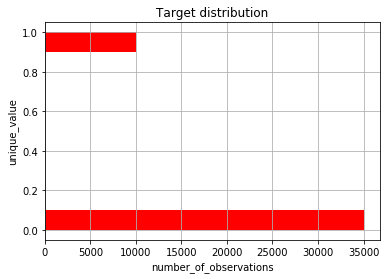

In [10]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Выберем названия всех признаков, кроме прогнозируемого

In [11]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Применяем функцию, заменяющую все значения NaN на медианное значение соответствующего столбца.

In [12]:
table = impute_nan_with_median(data)
table.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,5166.0,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Разделяем целевой признак и все остальные – получаем обучающую выборку. 

In [13]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

Выведем версии основных библиотек – результат `GridSearchCV`, например, может отличаться в разных версиях `sklearn` даже при фиксированном `random_state`.

In [14]:
#!pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [15]:
# update scikit-learn
#!pip install -U scikit-learn

In [16]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.5.2
IPython 6.1.0

numpy 1.13.0
scipy 0.19.0
pandas 0.20.2
matplotlib 2.0.2
sklearn 0.19.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.9.49-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 73ad0047b8f948cb28beed0152aa6a4571112be8


# Бутстрэп

**<font color='red'>Задание 2.</font>** Сделайте интервальную оценку (на основе бутстрэпа) среднего дохода (MonthlyIncome) клиентов, просрочивших выплату кредита, и отдельно – для вовремя заплативших. Стройте 90% доверительный интервал. Найдите разницу между нижней границей полученного интервала для не просрочивших кредит и верхней границей – для просрочивших. 
То есть вас просят построить 90%-ые интервалы для дохода "хороших" клиентов $[good\_income\_lower, good\_income\_upper]$ и для "плохих" – $[bad\_income\_lower, bad\_income\_upper]$ и найти разницу $good\_income\_lower - bad\_income\_upper$.

Используйте пример из [статьи](https://habrahabr.ru/company/ods/blog/324402/). Поставьте `np.random.seed(17)`. Округлите ответ до целых.

**<font color='red'>Варианты ответа:</font>**
- 345
- 425
- 585
- 655

In [17]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [18]:
np.random.seed(17)

bad_incomes = table['MonthlyIncome'][table['SeriousDlqin2yrs'] == 1].values
good_incomes = table['MonthlyIncome'][table['SeriousDlqin2yrs'] == 0].values

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
bad_incomes_mean_estimate = [np.mean(sample) for sample in get_bootstrap_samples(bad_incomes, 1000)]
good_incomes_mean_estimate = [np.mean(sample) for sample in get_bootstrap_samples(good_incomes, 1000)]

#  выводим интервальную оценку среднего
bad_income_lower, bad_income_upper = stat_intervals(bad_incomes_mean_estimate, 0.1)
good_income_lower, good_income_upper = stat_intervals(good_incomes_mean_estimate, 0.1)

print(int(good_income_lower - bad_income_upper))

652


# Дерево решений, подбор гиперпараметров

Одной из основных метрик качества модели является площадь под ROC-кривой. Значения ROC-AUC лежат от 0 до 1. Чем ближе значение ROC-AUC к 1, тем качественнее происходит классификация моделью.

Найдите с помощью `GridSearchCV` гиперпараметры `DecisionTreeClassifier`, максимизирующие площадь под ROC-кривой. 

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Используем модуль `DecisionTreeClassifier` для построения дерева решений. Из-за несбалансированности классов  в целевом признаке добавляем параметр балансировки. Используем также параметр `random_state=17` для воспроизводимости результатов.

In [20]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

Перебирать будем вот такие значения гиперпараметров:

In [21]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Зафиксируем кросс-валидацию: стратифицированная, 5 разбиений с перемешиванием, не забываем про `random_state`.

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

**<font color='red'>Задание 3.</font>**
Сделайте GridSearch с метрикой ROC AUC по гиперпараметрам из словаря `tree_params`. Какое максимальное значение ROC AUC получилось (округлите до 2 знаков после разделителя)? Назовем кросс-валидацию устойчивой, если стандартное отклонение метрики качества на кросс-валидации меньше 1%. Получилась ли кросс-валидация устойчивой при оптимальных сочетаниях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC на кросс-валидации)?

**<font color='red'>Варианты ответа:</font>**
- 0.82, нет
- 0.84, нет
- 0.82, да
- 0.84, да

In [23]:
%%time
grid = GridSearchCV(dt, param_grid=tree_params, n_jobs=-1, 
                    cv = skf, verbose = 1, scoring = 'roc_auc', 
                    return_train_score = True)
grid.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 290 ms, sys: 160 ms, total: 450 ms
Wall time: 2.38 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished


In [24]:
print("Mean score: %0.2f" % grid.cv_results_['mean_test_score'].mean())
print(grid.cv_results_['mean_test_score'])

Mean score: 0.81
[ 0.81089154  0.8043939   0.81111502  0.81487177  0.81574356  0.81615275
  0.8146449   0.81903996  0.81754694  0.81685585  0.82030235  0.81903131
  0.81448767  0.81661305  0.8148858   0.8163828   0.80887829  0.81197468
  0.80964848  0.80987945]


In [25]:
std = grid.cv_results_['mean_test_score'].std() * 100
print("Score deviation: %0.2f per cents" % std)

Score deviation: 0.39 per cents


In [26]:
grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

# Простая реализация случайного леса

**<font color='red'>Задание 4.</font>**
Реализуйте свой собственный случайный лес с помощью `DecisionTreeClassifier` с лучшими параметрами из прошлого задания. В нашем лесу будет 10 деревьев, предсказанные вероятности которых вам нужно усреднить. 

Краткая спецификация: 
 - Используйте основу ниже
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Почему именно так – неважно, главное чтоб на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести
 - Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`
 - Также сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов 
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`
 - В методе `predict_proba` опять нужен цикл по всем деревьям. У тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=7, max_features=6, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        features_num = X.shape[1]
        observation_num = X.shape[0]
        n_samples = 1000  # количество сэмплов для бутстрапа
        for i in range(0, self.n_estimators - 1):
            np.random.seed(self.random_state + i)
            # выберите без замещения max_features признаков, сохраните список выбранных id признаков в self.feat_ids_by_tree
            features_indices = np.random.choice(np.arange(0, features_num - 1), self.max_features, replace=False)
            # сделайте bootstrap-выборку (т.е. с замещением) из множества id объектов
            indices = np.random.randint(0, observation_num - 1, n_samples)
            # готовим дерево
            subtree = DecisionTreeClassifier(criterion='gini', max_depth=self.max_depth, 
                                   max_features=self.max_features, random_state=self.random_state)
            # обучаем
            subtree.fit(X.iloc[indices, features_indices], y.iloc[indices])
            self.feat_ids_by_tree.append(features_indices)            
            self.trees.append(subtree)
        return self
    
    def predict_proba(self, X):
        proba = np.zeros((X.shape[0], 2))
        for i in range(0, self.n_estimators - 1):
            subtree = self.trees[i]
            features_indices = self.feat_ids_by_tree[i]
            sub_proba = subtree.predict_proba(X.iloc[:, features_indices])
            proba += sub_proba
        return proba / self.n_estimators

In [30]:
# Cross validation with skf.split

# НЕДОПИСАН

from sklearn.metrics import roc_auc_score
rf = RandomForestClassifierCustom()

y_score = []

for train_indices, test_indices in skf.split(X, y):
    rf.fit(X.iloc[train_indices,:], y.iloc[train_indices])
    y_score = rf.predict_proba(X.iloc[test_indices, :])
#    print(y_score[1])
#
#roc_auc_score(y.iloc[idx], y_score)

In [31]:
rf = RandomForestClassifierCustom()
cross_val_score(rf, X, y, cv=6, scoring='roc_auc').mean()

0.83328639064585097

**<font color='red'>Задание 5.</font>**
Тут сравним нашу собственную реализацию случайного леса с `sklearn`-овской. Для этого воспользуйтесь `RandomForestClassifier(n_jobs=1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Какое среднее значение ROC AUC на кросс-валидации мы в итоге получили? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833
- 0.843
- 0.853

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_skl = RandomForestClassifier(n_jobs=-1, max_depth=7, max_features=6, random_state=17)
cross_val_score(rf_skl, X, y, cv=6, scoring='roc_auc').mean()

0.83124090442302767

# Случайный лес `sklearn`, подбор гиперпараметров

**<font color='red'>Задание 6.</font>** 
В 3 задании мы находили оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. Давайте проверим это с помощью `GridSearchCV` `(RandomForestClassifier(random_state=17)`).  Только теперь расширим перебираемые значения `max_depth` до 15 включительно, так как в лесу нужны деревья поглубже (а почему именно – вы поняли из [статьи](https://habrahabr.ru/company/ods/blog/324402/)). Какими теперь стали лучшие значения гиперпараметров?

**<font color='red'>Варианты ответа:</font>**
- `max_depth=8, max_features=4`
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [33]:
max_depth_values = range(5, 16)
max_features_values = range(4, 8)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [34]:
%%time
grid = GridSearchCV(rf_skl, cv=skf, param_grid = forest_params, scoring = 'roc_auc', n_jobs=-1)
grid.fit(X, y)

CPU times: user 1.74 s, sys: 290 ms, total: 2.03 s
Wall time: 36.5 s


In [450]:
grid.best_score_

0.83357996702526482

In [35]:
grid.best_params_

{'max_depth': 8, 'max_features': 4}

# Логистическая регрессия, подбор гиперпараметров

**<font color='red'>Задание 7.</font>**  Теперь сравним с логистической регрессией (укажем `class_weight='balanced'` и `random_state=17`). Сделайте полный перебор по параметру `C` из широкого диапазона значений `np.logspace(-8, 8, 17)`. 
Только сделаем это корректно и выстроим пайплайн – сначала масштабирование, затем обучение модели. 

Разберитесь с пайплайнами и проведите кросс-валидацию. Какое получилось лучшее значение средней ROC AUC? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.778
- 0.788
- 0.798
- 0.808

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [47]:
scaler.fit(X.values.reshape(-1, 1))
X_ = scaler.transform(X.values.reshape(-1, 1))

logit.fit(X_, y)

(315441, 1)

In [49]:
%%time
grid = GridSearchCV(logit_pipe, cv=skf, param_grid = logit_pipe_params, scoring = 'roc_auc', n_jobs=-1)
grid.fit(X, y)

CPU times: user 720 ms, sys: 130 ms, total: 850 ms
Wall time: 5.42 s


In [50]:
grid.best_score_

0.78786267573072055

# Логистическая регрессия и случайный лес на разреженных признаках

В случае небольшого числа признаков случайный лес показал себя лучше логистической регрессии. Однако один из главных недостатков деревьев проявляется при работе с разреженным данными, например с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Скачайте данные с отзывами к фильмам [отсюда](https://yadi.sk/d/pHZlDkg-3NSUQW).

In [61]:
# Загрузим данные
df = pd.read_csv("../../data/movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# в Pipeline будем сразу преобразовать наш текст и обучать логистическую регрессию
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))])

**<font color='red'>Задание 8.</font>** Сделайте полный перебор по параметру `C` из выборки [0.1, 1, 10, 100]. Какое лучшее значение ROC AUC получилось на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [65]:
%%time
estimator_params = {'clf__C': [0.1, 1, 10, 100]}
estimator = GridSearchCV(classifier, cv=skf, param_grid = estimator_params, 
                         scoring = 'roc_auc', n_jobs=-1, verbose = 1)
estimator.fit(X_text, y_text)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__C=0.1 ......................................................
[CV] clf__C=0.1 ......................................................
[CV] clf__C=0.1 ......................................................
[CV] clf__C=1 ........................................................
[CV] ....................................... clf__C=0.1, total=   8.0s
[CV] ....................................... clf__C=0.1, total=   8.0s
[CV] ....................................... clf__C=0.1, total=   8.1s
[CV] clf__C=1 ........................................................
[CV] clf__C=1 ........................................................
[CV] clf__C=10 .......................................................
[CV] ......................................... clf__C=1, total=   8.5s
[CV] clf__C=10 .......................................................
[CV] ......................................... clf__C=1, total=   9.3s
[CV] ............

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   36.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   36.0s finished


CPU times: user 11.6 s, sys: 330 ms, total: 12 s
Wall time: 47.8 s


In [66]:
estimator.best_score_

0.85869298711881148

**<font color='red'>Задание 9.</font>** Теперь попробуем сравнить со случайным лесом. Аналогично делаем перебор и получаем максимальное ROC AUC. Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [58]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [59]:
%%time
estimator_params = {'clf__min_samples_leaf': min_samples_leaf, 'clf__max_features': max_features, 'clf__max_depth': max_depth}
estimator = GridSearchCV(classifier, cv=skf, param_grid = estimator_params, 
                         scoring = 'roc_auc', n_jobs=-1, verbose=1)
estimator.fit(X_text, y_text)

CPU times: user 4min 47s, sys: 440 ms, total: 4min 47s
Wall time: 22min 33s


In [60]:
estimator.best_score_

0.74727464051458781

In [83]:
idx = np.random.randint(0, len(X_text))
X_text[idx], y_text[idx]

("It's as if Downey Sr.'s irreverence and off-the-wall humor couldn't quite co-exist with the heartfelt tribute he intends to make here to his wife and her fellow Amyotrophic Lateral Sclerosis sufferers.",
 0)